##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 사용자 정의 페더레이션 알고리즘, 2부: 페더레이션 평균화 구현하기

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/federated/tutorials/custom_federated_algorithms_2"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">View on TensorFlow.org</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/federated/blob/master/docs/tutorials/custom_federated_algorithms_2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/federated/blob/master/docs/tutorials/custom_federated_algorithms_2.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">View source on GitHub</a></td>
</table>

이 튜토리얼은 [페더레이션 학습(FL)](../federated_learning.md) 레이어(`tff.learning`)의 기반 역할을 하는 [Federated Core(FC)](../federated_core.md)를 사용하여 TFF에서 사용자 정의 형태의 페더레이션 알고리즘을 구현하는 방법을 보여주는 2부작 시리즈의 두 번째 부분입니다.

여기에 사용된 핵심 개념과 프로그래밍 추상화를 소개하는 [이 시리즈의 첫 번째 부분](custom_federated_algorithms_1.ipynb)을 먼저 읽어보기 바랍니다.

시리즈의 두 번째 부분에서는 첫 번째 부분에서 소개한 메커니즘을 사용하여 페더레이션 훈련 및 평가 알고리즘의 간단한 버전을 구현합니다.

TFF의 페더레이션 학습 API를 더 개괄적이고 평이한 수준으로 소개하는 [이미지 분류](federated_learning_for_image_classification.ipynb) 및 [텍스트 생성](federated_learning_for_text_generation.ipynb) 튜토리얼을 살펴볼 것을 권장합니다. 여기에서 설명하는 개념에 대한 배경을 이해하는 데 도움이 됩니다.

## Before we start

시작하기 전에 다음 "Hello World" 예제를 실행하여 환경이 올바르게 설정되었는지 확인하기 바랍니다. 작동하지 않으면 [설치](../install.md) 가이드의 지침을 참조하세요.

In [ ]:
#@test {"skip": true}
!pip install --quiet --upgrade tensorflow_federated_nightly
!pip install --quiet --upgrade nest_asyncio

import nest_asyncio
nest_asyncio.apply()

In [ ]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

# TODO(b/148678573,b/148685415): must use the ReferenceExecutor because it
# supports unbounded references and tff.sequence_* intrinsics.
tff.framework.set_default_context(tff.test.ReferenceExecutor())

In [ ]:
@tff.federated_computation
def hello_world():
  return 'Hello, World!'

hello_world()

'Hello, World!'

## 페더레이션 평균화 구현하기

[이미지 분류를 위한 페더레이션 학습](federated_learning_for_image_classification.ipynb)에서와 같이 MNIST 예제를 사용할 것입니다. 그러나 이 튜토리얼은 낮은 수준에서 준비한 것이므로 Keras API 및 `tff.simulation`을 건너뛰고 원시 모델 코드를 작성하며 페더레이션 데이터세트를 처음부터 구성합니다.


### 페더레이션 데이터세트 준비하기

데모를 위해 10명의 사용자로부터 얻은 데이터가 있고 각 사용자가 다른 숫자를 인식하는 방식에 대한 지식을 제공하는 시나리오를 시뮬레이션할 것입니다. 이 작업은 [i.i.d.](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables)로서 이루어집니다.

먼저 표준 MNIST 데이터를 로드하겠습니다.

In [ ]:
mnist_train, mnist_test = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
[(x.dtype, x.shape) for x in mnist_train]

[(dtype('uint8'), (60000, 28, 28)), (dtype('uint8'), (60000,))]

데이터는 Numpy 배열로 제공되며, 하나는 이미지가 있고 다른 하나는 숫자 레이블이 있으며, 둘 모두 첫 번째 차원은 개별 예제로 진행됩니다. 페더레이션 시퀀스를 TFF 계산에 제공하는 방식과 호환되는 방식으로 형식을 지정하는 도우미 함수를 작성해 보겠습니다. 즉, 목록의 목록이 이용되며 바깥 목록은 사용자(숫자)를 나열하고 안쪽 목록은 각 클라이언트 시퀀스에서 데이터 배치를 나열합니다. 항상 하던 대로 각각 선행하는 배치 차원이 있는 `x` 및 `y`라는 텐서 쌍으로 각 배치를 구성합니다. 여기서 또한 데이터 변환으로 모델 논리를 복잡하게 만들 필요가 없도록 각 이미지를 784개 요소 벡터로 평면화하고 그 내부의 픽셀 크기를 `0..1` 범위로 재조정합니다.

In [ ]:
NUM_EXAMPLES_PER_USER = 1000
BATCH_SIZE = 100


def get_data_for_digit(source, digit):
  output_sequence = []
  all_samples = [i for i, d in enumerate(source[1]) if d == digit]
  for i in range(0, min(len(all_samples), NUM_EXAMPLES_PER_USER), BATCH_SIZE):
    batch_samples = all_samples[i:i + BATCH_SIZE]
    output_sequence.append({
        'x':
            np.array([source[0][i].flatten() / 255.0 for i in batch_samples],
                     dtype=np.float32),
        'y':
            np.array([source[1][i] for i in batch_samples], dtype=np.int32)
    })
  return output_sequence


federated_train_data = [get_data_for_digit(mnist_train, d) for d in range(10)]

federated_test_data = [get_data_for_digit(mnist_test, d) for d in range(10)]

빠른 온전성 검사로 다섯 번째 클라이언트(숫자 `5`에 해당)가 제공한 데이터의 마지막 배치에서 `Y` 텐서를 살펴보겠습니다.

In [ ]:
federated_train_data[5][-1]['y']

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int32)

확실히 하기 위해 해당 배치의 마지막 요소에 해당하는 이미지도 살펴보겠습니다.

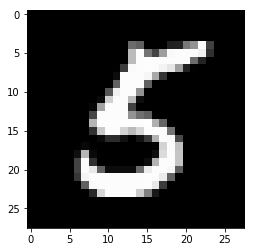

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(federated_train_data[5][-1]['x'][-1].reshape(28, 28), cmap='gray')
plt.grid(False)
plt.show()

### TensorFlow와 TFF를 결합할 때

이 튜토리얼에서는 간결하게 하기 위해 TensorFlow 논리를 도입하는 함수를 `tff.tf_computation`으로 즉시 데코레이팅합니다. 그러나 더 복잡한 논리의 경우 권장되는 패턴은 아닙니다. 그러지 않아도 TensorFlow 디버깅이 어려움을 줄 수 있는데, 완전히 직렬화한 다음 다시 가져온 후 TensorFlow를 디버깅하려면 필연적으로 일부 메타데이터가 손실되고 상호 작용이 제한되어 디버깅이 훨씬 더 어려워집니다.

따라서 **복잡한 TF 논리를 독립 실행형 Python 함수로 작성할 것을 강력히 권장합니다**(즉, `tff.tf_computation` 데코레이션을 사용하지 않음). 이렇게 하면 TFF에 대한 계산을 직렬화하기 전에 TF 모범 사례 및 도구(예: 즉시 실행 모드)를 사용하여 TensorFlow 논리를 개발하고 테스트할 수 있습니다(예: Python 함수를 인수로 사용하여 `tff.tf_computation`을 호출).

### 손실 함수 정의하기

이제 데이터를 얻었으므로 훈련에 사용할 수 있는 손실 함수를 정의하겠습니다. 먼저 입력 유형을 tuple이라는 TFF로 정의하겠습니다. 데이터 배치의 크기가 다를 수 있으므로 배치 차원을 `None`으로 설정하여 이 차원의 크기를 알 수 없는 것으로 나타냅니다.

In [ ]:
BATCH_SPEC = collections.OrderedDict(
    x=tf.TensorSpec(shape=[None, 784], dtype=tf.float32),
    y=tf.TensorSpec(shape=[None], dtype=tf.int32))
BATCH_TYPE = tff.to_type(BATCH_SPEC)

str(BATCH_TYPE)

'<x=float32[?,784],y=int32[?]>'

왜 일반적인 Python 유형을 정의할 수 없는지 궁금할 것입니다. [1부](custom_federated_algorithms_1.ipynb)에서 논의한 내용을 상기해 보세요. 즉, Python을 사용하여 TFF 계산의 논리를 표현할 수 있지만 내부적으로 TFF 계산은 Python이 *아니라고* 했습니다. 위에 정의한 `BATCH_TYPE` 기호는 추상적인 TFF 유형 사양을 나타냅니다. 이 *추상적* TFF 유형을 구체적인 Python *표현* 유형(예: Python 함수 본문에서 TFF 유형을 나타내는 데 사용할 수 있는 `dict` 또는 `collections.namedtuple`과 같은 컨테이너)과 구분하는 것이 중요합니다. Python과 달리 TFF에는 개별적으로 명명하거나 명명하지 않을 수 있는 요소와 함께 튜플과 유사한 컨테이너에 대한 단일 추상 유형 생성자 `tff.StructType`가 있습니다. TFF 계산은 공식적으로 하나의 매개변수와 하나의 결과만 선언할 수 있으므로 이 유형은 계산의 정식 매개변수를 모델링하는 데도 사용됩니다. 이에 대한 예제를 곧 살펴볼 것입니다.

이제 TFF 유형의 모델 매개변수를 이번에도 TFF 명명 튜플인 *weights* 및 *bias*로 정의해 보겠습니다.

In [ ]:
MODEL_SPEC = collections.OrderedDict(
    weights=tf.TensorSpec(shape=[784, 10], dtype=tf.float32),
    bias=tf.TensorSpec(shape=[10], dtype=tf.float32))
MODEL_TYPE = tff.to_type(MODEL_SPEC)

print(MODEL_TYPE)

<weights=float32[784,10],bias=float32[10]>


이러한 정의가 적용되면 이제 단일 배치에서 주어진 모델에 대한 손실을 정의할 수 있습니다. `@tf.function` 데코레이터 내부의 `@tff.tf_computation` 데코레이터 사용에 유의하세요. 이를 통해 `tff.tf_computation` 데코레이터에 의해 생성된 `tf.Graph` 컨텍스트 내부에 있음에도 불구하고 의미 체계와 같은 Python을 사용하여 TF를 작성할 수 있습니다.

In [ ]:
# NOTE: `forward_pass` is defined separately from `batch_loss` so that it can 
# be later called from within another tf.function. Necessary because a
# @tf.function  decorated method cannot invoke a @tff.tf_computation.

@tf.function
def forward_pass(model, batch):
  predicted_y = tf.nn.softmax(
      tf.matmul(batch['x'], model['weights']) + model['bias'])
  return -tf.reduce_mean(
      tf.reduce_sum(
          tf.one_hot(batch['y'], 10) * tf.math.log(predicted_y), axis=[1]))

@tff.tf_computation(MODEL_TYPE, BATCH_TYPE)
def batch_loss(model, batch):
  return forward_pass(model, batch)

예상하는 바와 같이 계산 `batch_loss`는 주어진 모델과 단일 데이터를 고려하여 `float32` 손실을 반환합니다. `MODEL_TYPE` 및 `BATCH_TYPE`이 2-튜플 공식 매개변수로 묶여진 것에 주목하세요. `batch_loss` 유형을 `(<MODEL_TYPE,BATCH_TYPE> -> float32)`로 인식할 수 있습니다.

In [ ]:
str(batch_loss.type_signature)

'(<<weights=float32[784,10],bias=float32[10]>,<x=float32[?,784],y=int32[?]>> -> float32)'

온전성 검사로 0으로 채워진 초기 모델을 구성하고 위에서 시각화한 데이터 배치에 대해 손실을 계산해 보겠습니다.

In [ ]:
initial_model = collections.OrderedDict(
    weights=np.zeros([784, 10], dtype=np.float32),
    bias=np.zeros([10], dtype=np.float32))

sample_batch = federated_train_data[5][-1]

batch_loss(initial_model, sample_batch)

2.3025854

초기 모델을 정의하는 Python 함수 본문이 모델 매개변수를 `model['weight']` 및 `model['bias']`로 소비하지만 이 모델을 `dict`으로 정의하여 TFF 계산을 제공한다는 점에 유의하세요. `batch_loss`에 대한 호출의 인수는 단순히 이 함수의 본문에 전달되는 것이 아닙니다.

`batch_loss`를 호출하면 어떻게 될까요? `batch_loss`의 Python 본문은 이미 정의된 위 셀에서 추적 및 직렬화되었습니다. TFF는 계산 정의 시간에 `batch_loss`에 대한 호출자 역할을 하고 `batch_loss`가 호출될 때 호출 대상 역할을 합니다. 두 역할 모두에서 TFF는 TFF의 추상 유형 시스템과 Python 표현 유형 사이에서 가교 역할을 합니다. 호출 시 TFF는 대부분의 표준 Python 컨테이너 유형(`dict`, `list`, `tuple`, `collections.namedtuple` 등)을 추상 TFF 튜플의 구체적인 표현으로 받아들입니다. 또한 위에서 언급했듯이 TFF 계산은 공식적으로 단일 매개변수만 허용하지만 매개변수 유형이 튜플인 경우 위치 및/또는 키워드 인수와 함께 익숙한 Python 호출 구문을 사용할 수 있습니다. 예상대로 작동합니다.

### 단일 배치에서의 경사 하강

이제 이 손실 함수를 사용하여 경사 하강의 단일 스텝을 수행하는 계산을 정의해 보겠습니다. 이 함수를 정의할 때 `batch_loss`를 하위 구성 요소로 사용하는 방식에 유의하세요. 다른 계산의 본문 내에서 `tff.tf_computation`으로 구성된 계산을 호출할 수 있지만 일반적으로 필요하지 않습니다. 위에서 언급했듯이 직렬화로 일부 디버깅 정보가 손실되기 때문에 이러한 호출은 `tff.tf_computation` 데코레이터 없이 모든 TensorFlow를 작성하고 테스트하는 더욱 복잡한 계산에 바람직한 경우가 많습니다.

In [ ]:
@tff.tf_computation(MODEL_TYPE, BATCH_TYPE, tf.float32)
def batch_train(initial_model, batch, learning_rate):
  # Define a group of model variables and set them to `initial_model`. Must
  # be defined outside the @tf.function.
  model_vars = collections.OrderedDict([
      (name, tf.Variable(name=name, initial_value=value))
      for name, value in initial_model.items()
  ])
  optimizer = tf.keras.optimizers.SGD(learning_rate)

  @tf.function
  def _train_on_batch(model_vars, batch):
    # Perform one step of gradient descent using loss from `batch_loss`.
    with tf.GradientTape() as tape:
      loss = forward_pass(model_vars, batch)
    grads = tape.gradient(loss, model_vars)
    optimizer.apply_gradients(
        zip(tf.nest.flatten(grads), tf.nest.flatten(model_vars)))
    return model_vars

  return _train_on_batch(model_vars, batch)

In [ ]:
str(batch_train.type_signature)

'(<<weights=float32[784,10],bias=float32[10]>,<x=float32[?,784],y=int32[?]>,float32> -> <weights=float32[784,10],bias=float32[10]>)'

이러한 다른 함수의 본문 내에서 `tff.tf_computation`으로 데코레이팅된 Python 함수를 호출하면 내부 TFF 계산의 논리가 외부 논리에 포함됩니다(본질적으로 인라인이 됨). 위에서 언급했듯이 두 계산을 모두 작성하는 경우 내부 함수(이 경우 `batch_loss`)를 `tff.tf_computation` 대신 일반 Python 또는 `tf.function`으로 만드는 것이 좋습니다. 그러나 여기서는 다른 함수 내에서 어떤 함수의 `tff.tf_computation`을 호출하면 기본적으로 예상대로 동작함을 보여줍니다. 예를 들어 `batch_loss`를 정의하는 Python 코드가 없고 직렬화된 TFF 표현만 있는 경우에 이렇게 해야 할 수 있습니다.

이제 이 함수를 초기 모델에 몇 번 적용하여 손실이 감소하는지 확인하겠습니다.

In [ ]:
model = initial_model
losses = []
for _ in range(5):
  model = batch_train(model, sample_batch, 0.1)
  losses.append(batch_loss(model, sample_batch))

In [ ]:
losses

[0.19690022, 0.13176313, 0.10113226, 0.082738124, 0.0703014]

### 일련의 로컬 데이터에 대한 경사 하강

이제 `batch_train`이 작동하는 것으로 보이므로 단일 배치가 아닌 한 사용자로부터 모든 배치의 전체 시퀀스를 소비하는 유사한 훈련 함수 `local_train`을 작성해 보겠습니다. 새 계산은 이제 `BATCH_TYPE` 대신 `tff.SequenceType(BATCH_TYPE)`을 사용해야 합니다.

In [ ]:
LOCAL_DATA_TYPE = tff.SequenceType(BATCH_TYPE)

@tff.federated_computation(MODEL_TYPE, tf.float32, LOCAL_DATA_TYPE)
def local_train(initial_model, learning_rate, all_batches):

  # Mapping function to apply to each batch.
  @tff.federated_computation(MODEL_TYPE, BATCH_TYPE)
  def batch_fn(model, batch):
    return batch_train(model, batch, learning_rate)

  return tff.sequence_reduce(all_batches, initial_model, batch_fn)

In [ ]:
str(local_train.type_signature)

'(<<weights=float32[784,10],bias=float32[10]>,float32,<x=float32[?,784],y=int32[?]>*> -> <weights=float32[784,10],bias=float32[10]>)'

이 짧은 코드 섹션에는 몇 가지 세부 사항이 숨겨져 있으므로 하나씩 살펴보겠습니다.

첫째, `tf.data.Dataset.reduce`를 사용하여 이전에 수행한 것과 유사하게 시퀀스를 처리하여 이 논리를 TensorFlow에서 완전히 구현할 수 있지만 이번에는 논리를 접착 언어에서 `tff.federated_computation`로 표현하도록 선택했습니다. 축소를 수행하기 위해 페더레이션 연산자 `tff.sequence_reduce`를 사용했습니다.

연산자 `tff.sequence_reduce`는 `tf.data.Dataset.reduce`와 유사하게 사용됩니다. 기본적으로 `tf.data.Dataset.reduce`와 동일하다고 생각할 수 있지만, 기억하신다면, TensorFlow 코드를 포함할 수 없는 페더레이션 계산 내에서 사용하기 위한 것입니다. 이 연산자는 `T` 유형 요소의 *시퀀스*, 일부 유형 `U`의 초기 축소 상태(이를 추상적으로 *0*이라고 하겠음), 및 단일 요소를 처리하여 축소 상태를 변경하는 `(<U,T> -> U)` 유형의 *축소 연산자*로 구성된 정식 매개변수 3-튜플을 포함한 템플릿 연산자입니다. 결과는 모든 요소를 순차적으로 처리한 후 축소의 최종 상태입니다. 이 예에서 축소 상태는 데이터의 앞부분에 대해 훈련된 모델이고 요소는 데이터 배치입니다.

둘째, 하나의 계산(`batch_train`)을 다른 계산( `local_train`) 내의 구성 요소로 다시 사용했지만 직접 사용하지는 않았다는 점에 주목하세요. 학습률이라는 추가 매개변수가 필요하기 때문에 이 계산을 축소 연산자로 사용할 수 없습니다. 이 문제를 해결하기 위해 본문에서 `local_train`의 매개변수 `learning_rate`에 바인딩되는 내장된 페더레이션 계산 `batch_fn`을 정의합니다. 하위 계산이 상위의 본문 내에서 호출되지만 않으면 이런 식으로 정의된 하위 계산이 상위 계산의 정식 매개변수를 포착할 수 있습니다. 이 패턴은 Python의 `functools.partial`과 동일한 것으로 생각할 수 있습니다.

이러한 방식으로 `learning_rate`를 포착한다는 것의 실제 의미는 물론 모든 배치에서 동일한 학습률 값이 사용된다는 것입니다.

이제 샘플 배치(숫자 `5`)를 제공한 동일한 사용자의 전체 데이터 시퀀스에 대해 새로 정의된 로컬 훈련 함수를 시도해 보겠습니다.

In [ ]:
locally_trained_model = local_train(initial_model, 0.1, federated_train_data[5])

효과가 있나요? 이 질문에 답하려면 평가를 구현해야 합니다.

### 로컬 평가

다음은 모든 데이터 배치에서 손실을 합산하여 로컬 평가를 구현하는 한 가지 방법입니다(방금 전에 평균도 계산할 수 있었을 테지만 독자를 위한 연습으로 남겨 두었음).

In [ ]:
@tff.federated_computation(MODEL_TYPE, LOCAL_DATA_TYPE)
def local_eval(model, all_batches):
  # TODO(b/120157713): Replace with `tff.sequence_average()` once implemented.
  return tff.sequence_sum(
      tff.sequence_map(
          tff.federated_computation(lambda b: batch_loss(model, b), BATCH_TYPE),
          all_batches))

In [ ]:
str(local_eval.type_signature)

'(<<weights=float32[784,10],bias=float32[10]>,<x=float32[?,784],y=int32[?]>*> -> float32)'

다시 말하지만, 이 코드에 설명된 몇 가지 새로운 요소가 있습니다. 하나씩 살펴보겠습니다.

첫째, 시퀀스를 처리하기 위한 두 개의 새로운 페더레이션 연산자를 사용했습니다. 이 두 가지 연산자는 각각, *매핑 함수* `T->U`와 `T`의 *시퀀스*를 받아서 매핑 함수를 포인트 단위로 적용하여 얻은 `U`의 시퀀스를 출력하는 `tff.sequence_map`, 그리고 모든 요소를 합산하는 `tff.sequence_sum`입니다. 여기에서는 각 데이터 배치를 손실 값에 매핑한 다음 결과적인 손실 값을 추가하여 총 손실을 계산합니다.

이번에도 `tff.sequence_reduce`를 사용할 수 있었지만 이것이 최선의 선택은 아닙니다. 축소 프로세스는 정의에 따라 순차적인 반면 매핑과 합계는 병렬로 계산될 수 있습니다. 선택이 주어지면 구현 선택을 제한하지 않는 연산자를 고수하는 것이 가장 좋습니다. 그러면 향후 특정 환경에 배포하기 위해 TFF 계산을 컴파일할 때 모든 잠재적 기회를 최대한 활용하여 더 빠르고 확장 가능하며 자원 효율적인 실행 결과를 얻을 수 있기 때문입니다.

둘째, `local_train`에서와 마찬가지로 필요한 구성 요소 함수(`batch_loss`)는 페더레이션 연산자(`tff.sequence_map`)가 예상하는 것보다 많은 매개변수를 사용한다는 점에 주목하세요. 그래서 마찬가지로 `lambda`를 `tff.federated_computation`으로 직접 래핑하여 이번에는 인라인으로 일부를 정의합니다. 인수로서 래퍼를 함수와 인라인으로 사용하는 방법은 `tff.tf_computation`를 사용하여 TensorFlow 논리를 TFF에 포함하는 권장 방식입니다.

이제 훈련이 효과가 있었는지 살펴보겠습니다.

In [ ]:
print('initial_model loss =', local_eval(initial_model,
                                         federated_train_data[5]))
print('locally_trained_model loss =',
      local_eval(locally_trained_model, federated_train_data[5]))

initial_model loss = 23.025854
locally_trained_model loss = 0.4348469


실제로 손실이 감소했습니다. 하지만 다른 사용자의 데이터에서 평가했을 때는 어떻게 될까요?

In [ ]:
print('initial_model loss =', local_eval(initial_model,
                                         federated_train_data[0]))
print('locally_trained_model loss =',
      local_eval(locally_trained_model, federated_train_data[0]))

initial_model loss = 23.025854
locally_trained_model loss = 74.50075


예상대로 상황이 악화되었습니다. 이 모델은 `5`를 인식하도록 훈련되었으며 `0`을 본 적이 없습니다. 그러면 이제 로컬 훈련이 글로벌 관점에서 모델의 품질에 어떤 영향을 미쳤을까?라는 의문이 듭니다.

### 페더레이션 평가

마침내 긴 여정을 거쳐 처음 출발했던 주제인 페더레이션 유형과 페더레이션 계산으로 다시 돌아왔습니다. 다음은 서버에서 비롯되는 모델에 대한 한 쌍의 TFF 유형 정의와 클라이언트에 남아 있는 데이터입니다.

In [ ]:
SERVER_MODEL_TYPE = tff.FederatedType(MODEL_TYPE, tff.SERVER)
CLIENT_DATA_TYPE = tff.FederatedType(LOCAL_DATA_TYPE, tff.CLIENTS)

지금까지 소개한 모든 정의를 이용해 TFF에서 페더레이션 평가를 한 줄로 표현할 수 있습니다. 즉, 모델을 클라이언트에 배포하고 각 클라이언트가 데이터의 로컬 부분에 대해 로컬 평가를 호출한 다음 손실을 평균화하도록 한다는 것입니다. 다음은 이것을 작성하는 한 가지 방법입니다.

In [ ]:
@tff.federated_computation(SERVER_MODEL_TYPE, CLIENT_DATA_TYPE)
def federated_eval(model, data):
  return tff.federated_mean(
      tff.federated_map(local_eval, [tff.federated_broadcast(model), data]))

더 간단한 시나리오에서 `tff.federated_mean` 및 `tff.federated_map`의 예를 이미 보았고, 직관적인 수준에서는 예상대로 작동하지만 이 코드 섹션에는 그 이상의 의미가 담겨 있습니다. 그러면 찬찬히 살펴보도록 하겠습니다.

먼저, *각 클라이언트가 데이터의 로컬 부분에 대해 로컬 평가를 호출하도록 한다*는 부분을 자세히 분석하겠습니다. 이전 섹션의 내용을 기억하겠지만 `local_eval`에는 `(<MODEL_TYPE, LOCAL_DATA_TYPE> -> float32)` 형식의 형식 서명이 있습니다.

페더레이션 연산자 `tff.federated_map`은 일부 유형 `T->U`의 *매핑 함수*와 `{T}@CLIENTS` 유형의 페더레이션 값으로 구성된 2-튜플을 매개변수로 받아들이고(즉, 매핑 함수의 매개변수와 동일한 유형의 구성원 구성 요소) `{U}@CLIENTS` 유형의 결과를 반환하는 템플릿입니다.

클라이언트별로 적용할 매핑 함수로 `local_eval`을 제공하므로 두 번째 인수는 페더레이션 유형 `{<MODEL_TYPE, LOCAL_DATA_TYPE>}@CLIENTS`이어야 합니다. 즉, 이전 섹션의 명명법에 따라 페더레이션 튜플이어야 합니다. 각 클라이언트는 `local_eval`에 대한 전체 인수 집합을 구성원 구성 요소로 가지고 있어야 합니다. 대신, 여기서는 2-요소 Python `list`를 제공합니다. 어떤 일이 일어날까요?

`float`를 받아들이는 함수에 `int`를 제공할 때와 같이 다른 곳에서 경험했을 수 있는 암시적 형식 캐스팅과 비슷하게, 이 예는 실제로 TFF에서 *암시적 형식 캐스팅*을 보여줍니다. 암시적 캐스팅은 이 시점에서 거의 사용되지 않지만 상용구를 최소화하기 위한 방법으로 TFF에 더 많이 도입할 계획입니다.

이 경우에 적용되는 암시적 캐스팅은 `{<X,Y>}@Z` 형식의 페더레이션 튜플과 페더레이션 값 `<{X}@Z,{Y}@Z>` 튜플 간의 동등성입니다. 공식적으로 이 두 가지 유형은 프로그래머의 관점에서 보면 서로 다른 형식 서명이지만 `Z`의 각 기기는 두 단위의 데이터 `X` 및 `Y`를 보유합니다. 여기서 일어나는 상황은 Python의 `zip`과 다르지 않으며 실제로 이러한 변환을 명시적으로 수행할 수 있도록 해주는 연산자 `tff.federated_zip`을 제공합니다. `tff.federated_map`에 두 번째 인수로 튜플이 제공되면 단순히 `tff.federated_zip`을 자동으로 호출합니다.

위와 같이 이제 `tff.federated_broadcast(model)` 표현식을 TFF 유형 `{MODEL_TYPE}@CLIENTS`의 값을 나타내는 것으로, 그리고 `data`를 TFF 유형 `{LOCAL_DATA_TYPE}@CLIENTS`(또는 간단히 `CLIENT_DATA_TYPE`)의 값을 나타내는 것으로 생각할 수 있습니다. 이 두 가지 유형은 암시적 `tff.federated_zip`를 통해 함께 필터링되어 `tff.federated_map`에 대한 두 번째 인수를 형성합니다.

연산자 `tff.federated_broadcast`는 예상대로 서버에서 클라이언트로 단순히 데이터를 전송합니다.

이제 로컬 훈련이 시스템의 평균 손실에 어떤 영향을 미쳤는지 살펴보겠습니다.

In [ ]:
print('initial_model loss =', federated_eval(initial_model,
                                             federated_train_data))
print('locally_trained_model loss =',
      federated_eval(locally_trained_model, federated_train_data))

initial_model loss = 23.025852
locally_trained_model loss = 54.432625


실제로 예상하는 바와 같이 손실이 증가했습니다. 모든 사용자를 위해 모델을 개선하려면 각 사용자의 데이터에 대해 훈련이 필요합니다.

### 페더레이션 훈련

페더레이션 훈련을 구현하는 가장 간단한 방법은 로컬에서 훈련한 다음 모델을 평균화하는 것입니다. 그러면 아래에서 볼 수 있듯이 이미 논의한 동일한 빌딩 블록과 패턴을 사용합니다.

In [ ]:
SERVER_FLOAT_TYPE = tff.FederatedType(tf.float32, tff.SERVER)


@tff.federated_computation(SERVER_MODEL_TYPE, SERVER_FLOAT_TYPE,
                           CLIENT_DATA_TYPE)
def federated_train(model, learning_rate, data):
  return tff.federated_mean(
      tff.federated_map(local_train, [
          tff.federated_broadcast(model),
          tff.federated_broadcast(learning_rate), data
      ]))

모델을 평균화하는 대신 `tff.learning`에서 제공하는 페더레이션 평균화를 모든 기능을 갖춰 구현할 때는 업데이트 기준을 자를 수 있고 압축에 유리한 점 등 여러 가지 이유로 모델 차이를 평균화하는 것이 바람직합니다.

몇 차례의 훈련을 실행하고 전후의 평균 손실을 비교하여 훈련이 제대로 작동하는지 살펴보겠습니다.

In [ ]:
model = initial_model
learning_rate = 0.1
for round_num in range(5):
  model = federated_train(model, learning_rate, federated_train_data)
  learning_rate = learning_rate * 0.9
  loss = federated_eval(model, federated_train_data)
  print('round {}, loss={}'.format(round_num, loss))

round 0, loss=21.60552406311035
round 1, loss=20.365678787231445
round 2, loss=19.27480125427246
round 3, loss=18.31110954284668
round 4, loss=17.45725440979004


완전하게 하기 위해 이제 테스트 데이터에서 실행하여 모델이 잘 일반화되는지 확인하겠습니다.

In [ ]:
print('initial_model test loss =',
      federated_eval(initial_model, federated_test_data))
print('trained_model test loss =', federated_eval(model, federated_test_data))

initial_model test loss = 22.795593
trained_model test loss = 17.278767


This concludes our tutorial.

물론 여기서 단순화시킨 예는 보다 현실적인 시나리오에서 수행해야 하는 많은 작업을 반영하지 않습니다. 예를 들어 손실 이외의 메트릭을 계산하지 않았습니다. 보다 완전한 예로 `tff.learning`에서 페더레이션 평균화의 [구현](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/learning/federated_averaging.py)을 연구해보는 것도 좋을 것입니다. 권장되는 코딩 방식을 실제로 확인하는 기회도 될 것입니다.